## Import libraries:

In [77]:
from imports import *

# Individual coordinate reconstruction (t,x,y,z)

In [78]:
image = np.load("/data/vidales/images/image_realistic_4comp_bunch_centered_v2701.npy")

**hit_nuvT variable loading**

In [79]:
table = pq.read_table('/home/vidales/AI_nuvT/saved_archives/ophit_variables_bunch_centered_v2701.parquet')
nuvT_c= ak.from_iter(table.column('nuvT_c_bunch').to_pylist())
del table

In [80]:
nuvT_c_np = ak.to_numpy(nuvT_c)

# Calculate mean and standard deviation of the original data
mu = np.mean(nuvT_c_np)
std = np.std(nuvT_c_np)

In [81]:
# Standardize the data (mean=0, std=1)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
nuvT_c_scaled = scaler.fit_transform(nuvT_c_np)

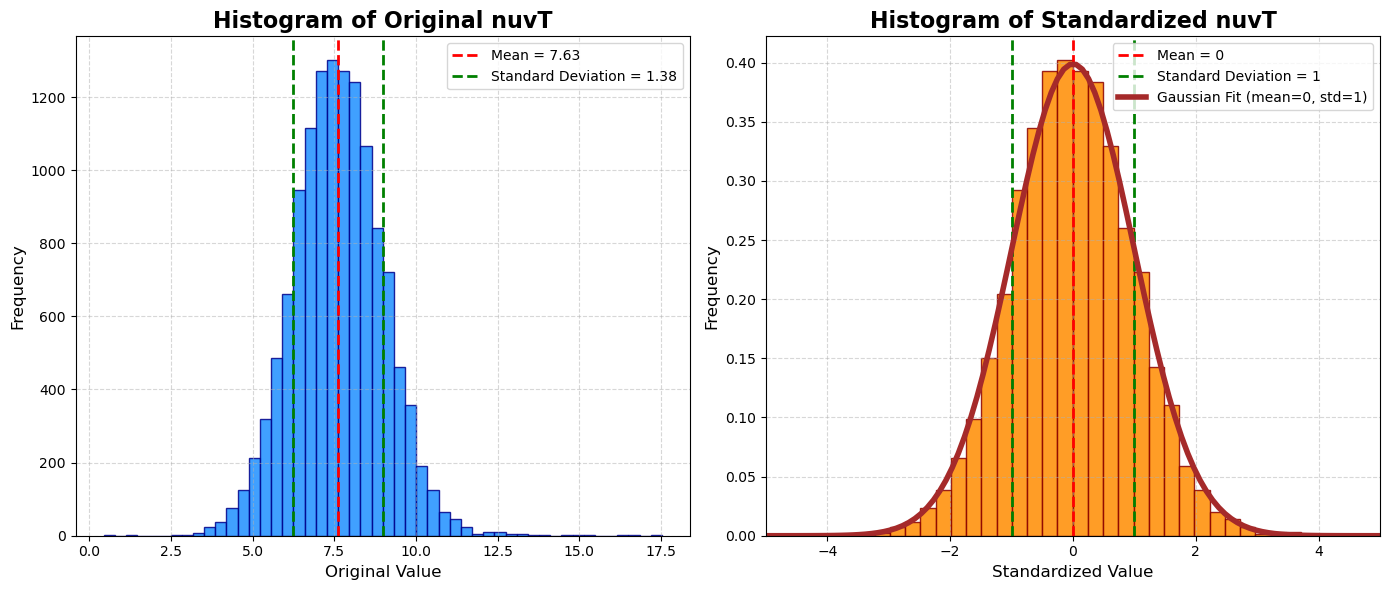

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler


# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot the histogram of the original (non-standardized) data
axs[0].hist(nuvT_c_np, bins=50, color='dodgerblue', edgecolor='darkblue', alpha=0.85, density=False)
axs[0].set_title('Histogram of Original nuvT', fontsize=16, fontweight='bold')
axs[0].set_xlabel('Original Value', fontsize=12)
axs[0].set_ylabel('Frequency', fontsize=12)

# Plot mean and std for original data
axs[0].axvline(mu, color='red', linestyle='dashed', linewidth=2, label=f'Mean = {mu:.2f}')
axs[0].axvline(mu + std, color='green', linestyle='dashed', linewidth=2, label=f'Standard Deviation = {std:.2f}')
axs[0].axvline(mu - std, color='green', linestyle='dashed', linewidth=2)
axs[0].legend()

axs[0].grid(True, linestyle='--', alpha=0.5)

# Plot the histogram of the standardized data
axs[1].hist(nuvT_c_scaled, bins=50, color='darkorange', edgecolor='darkred', alpha=0.85, density=True)  # Normalize the histogram
axs[1].set_title('Histogram of Standardized nuvT', fontsize=16, fontweight='bold')
axs[1].set_xlabel('Standardized Value', fontsize=12)
axs[1].set_ylabel('Frequency', fontsize=12)
axs[1].set_xlim(-5, 5)

# Plot mean and std for standardized data
axs[1].axvline(0, color='red', linestyle='dashed', linewidth=2, label='Mean = 0')
axs[1].axvline(1, color='green', linestyle='dashed', linewidth=2, label='Standard Deviation = 1')
axs[1].axvline(-1, color='green', linestyle='dashed', linewidth=2)

# Fit a Gaussian (normal distribution) to the standardized data
xmin, xmax = axs[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, 0, 1)  # Standard Gaussian (mean=0, std=1)

# Plot the Gaussian fit
axs[1].plot(x, p, 'brown', linewidth=4, label='Gaussian Fit (mean=0, std=1)')
axs[1].legend()

axs[1].grid(True, linestyle='--', alpha=0.5)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

**Model architecture definition**

## 4-component realistic representation

**Training and set separation**

In [83]:
test_size = int(np.floor(0.20*np.shape(nuvT_c)[0]) )
print(test_size)

2609


In [84]:
# prueba (los mapas originales están invertidos en y)
# Invert along the 59 dimension (axis 1)
inverted_image = image[:, ::-1, :, :]

In [85]:
x_train, x_test = inverted_image[:-test_size], inverted_image[-test_size:]
print('x_train dim.:',x_train.shape)
print('x_test dim.:', x_test.shape)

x_train dim.: (10439, 59, 70, 16)
x_test dim.: (2609, 59, 70, 16)


In [86]:
y_train, y_test = nuvT_c_scaled[:-test_size], nuvT_c_scaled[-test_size:]
#y_train, y_test = nuvT_c_np[:-test_size], nuvT_c_np[-test_size:]

In [87]:
print(y_train.shape)

(10439, 1)


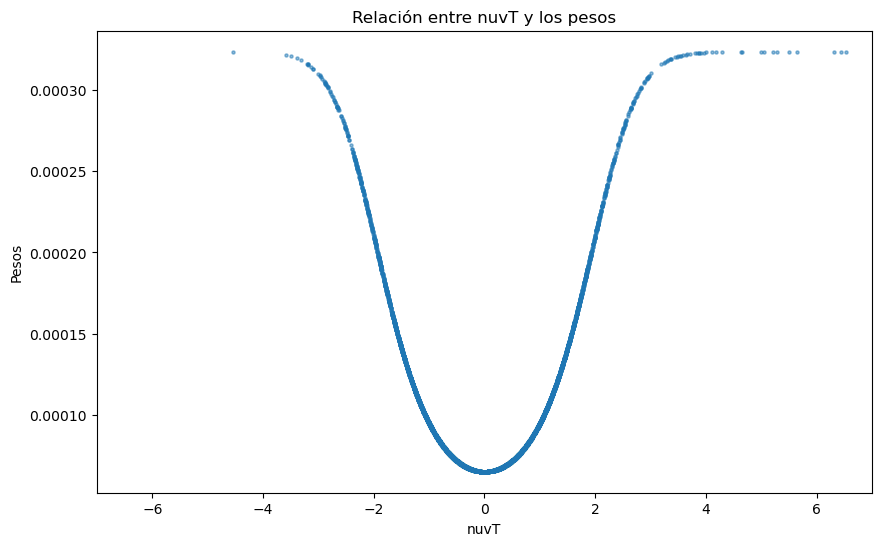

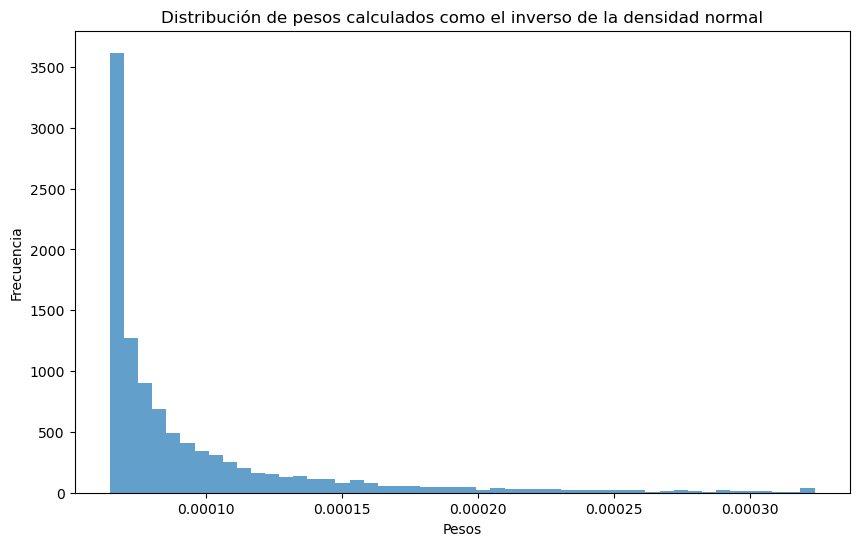

In [88]:
import numpy as np
import matplotlib.pyplot as plt

# Calcular los pesos como el inverso de la densidad normal de forma controlada
def compute_controlled_weights(y_values):
    # Calcular la densidad normal en cada valor
    pdf = (1 / np.sqrt(2 * np.pi)) * np.exp(-0.5 * y_values**2)
    
    # Invertir la densidad de forma moderada
    weights = 1 / (pdf + 1e-1)  # Añadir un pequeño valor para evitar división por 0
    
    # Normalizamos los pesos para que su suma sea 1
    weights /= np.sum(weights)
    
    return weights

# Calcular los pesos
y_weights = compute_controlled_weights(y_train)

# Graficar la relación entre los valores originales y sus pesos
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_weights, alpha=0.5, s=5)
plt.title("Relación entre nuvT y los pesos")
plt.xlabel("nuvT")
plt.ylabel("Pesos")
plt.xlim(-7,7)
plt.show()

# Graficar los pesos
plt.figure(figsize=(10, 6))
plt.hist(y_weights, bins=50, alpha=0.7)
plt.title("Distribución de pesos calculados como el inverso de la densidad normal")
plt.xlabel("Pesos")
plt.ylabel("Frecuencia")
plt.show()

In [89]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Input layer
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
input_layer = layers.Input(shape=input_shape)

# First convolutional block
model = layers.Conv2D(32, (5,5), padding='same', kernel_regularizer=regularizers.l2(0.01))(input_layer)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Second convolutional block
model = layers.Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Third convolutional block
model = layers.Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D((2,2), padding='same')(model)

# Fourth convolutional block
model = layers.Conv2D(256, (3,3), padding='same', kernel_regularizer=regularizers.l2(0.01))(model)
model = layers.BatchNormalization()(model)
model = layers.LeakyReLU(alpha=0.1)(model)

# Flatten the output and pass through dense layers
model = layers.Flatten()(model)
model = layers.Dense(1024, activation='relu')(model)
model = layers.Dropout(0.3)(model)
model = layers.Dense(512, activation='relu')(model)
model = layers.Dropout(0.3)(model)
model = layers.Dense(256, activation='relu')(model)
model = layers.Dropout(0.3)(model)
model = layers.Dense(128, activation='relu')(model)
model = layers.Dropout(0.3)(model)

# Output layer
output_layer = layers.Dense(1, activation='linear')(model)

# Create the model
model = models.Model(inputs=input_layer, outputs=output_layer)

# Compile the model with the weighted loss
model.compile(optimizer= Adam(learning_rate=1e-4), loss='mse')


In [90]:
from tensorflow.keras.callbacks import EarlyStopping

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=16,
    validation_data=(x_test, y_test),
    #sample_weight= y_weights,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/10
653/653 [==============================] - 9s 12ms/step - loss: 4.4597 - val_loss: 3.9491
Epoch 2/10
653/653 [==============================] - 6s 10ms/step - loss: 3.7818 - val_loss: 3.5173
Epoch 3/10
653/653 [==============================] - 6s 10ms/step - loss: 3.2857 - val_loss: 3.0169
Epoch 4/10
653/653 [==============================] - 6s 10ms/step - loss: 2.7611 - val_loss: 2.4941
Epoch 5/10
653/653 [==============================] - 7s 11ms/step - loss: 2.2755 - val_loss: 2.0362
Epoch 6/10
653/653 [==============================] - 6s 10ms/step - loss: 1.8837 - val_loss: 1.7332
Epoch 7/10
653/653 [==============================] - 6s 10ms/step - loss: 1.5804 - val_loss: 1.4335
Epoch 8/10
653/653 [==============================] - 6s 10ms/step - loss: 1.3337 - val_loss: 1.2408
Epoch 9/10
653/653 [==============================] - 6s 10ms/step - loss: 1.2125 - val_loss: 1.1445
Epoch 10/10
653/653 [==============================] - 6s 10ms/step - loss: 1.1116 - val_lo

In [96]:
# Make predictions on the test set
y_pred = model.predict(x_test)

## Visualización de resultados

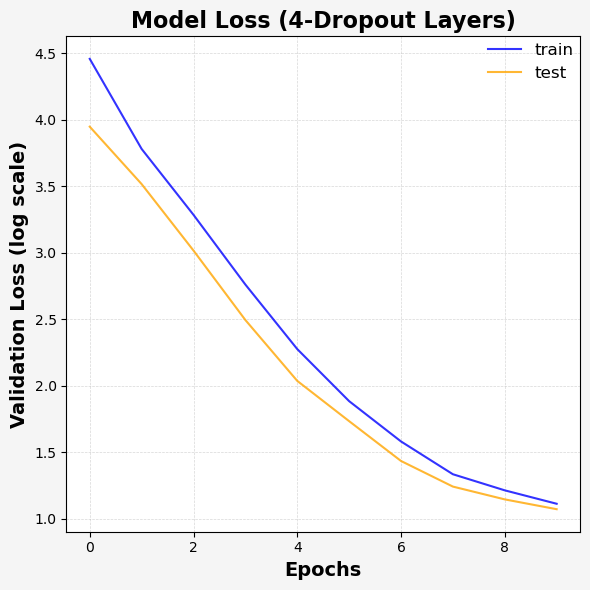

In [92]:
import matplotlib.pyplot as plt

# Access each model's history
model_history = history.history

# Plotting the validation loss for all models
plt.figure(figsize=(6, 6))

# Plot each model's validation loss with smooth lines, subtle markers, and refined styling
plt.plot(model_history['loss'], label='train', color='blue', linestyle='-', markersize=8, alpha=0.8)
plt.plot(model_history['val_loss'], label='test', color='orange', linestyle='-', markersize=8, alpha=0.8)

# Enhance plot appearance
#plt.yscale('log')  # Use logarithmic scale on y-axis
#plt.ylim()
plt.xlabel('Epochs', fontsize=14, fontweight='bold')
plt.ylabel('Validation Loss (log scale)', fontsize=14, fontweight='bold')
plt.title('Model Loss (4-Dropout Layers)', fontsize=16, fontweight='bold')
#plt.ylim(0.1,0.3)
# Refined grid with lighter lines
plt.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)

# Add legend with better positioning and larger font
plt.legend(fontsize=12, loc='upper right', bbox_to_anchor=(1, 1), borderaxespad=0., frameon=False)

# Add background color for plot to make it stand out
plt.gcf().set_facecolor('whitesmoke')

# Show plot with a tight layout to avoid clipping
plt.tight_layout()
plt.show()


In [93]:
# Initialize a copy of the scaled combined data
y_pred_inverse= np.copy(y_pred)
y_test_inverse= np.copy(y_test)

y_pred_inverse = scaler.inverse_transform(y_pred)
y_test_inverse= scaler.inverse_transform(y_test)

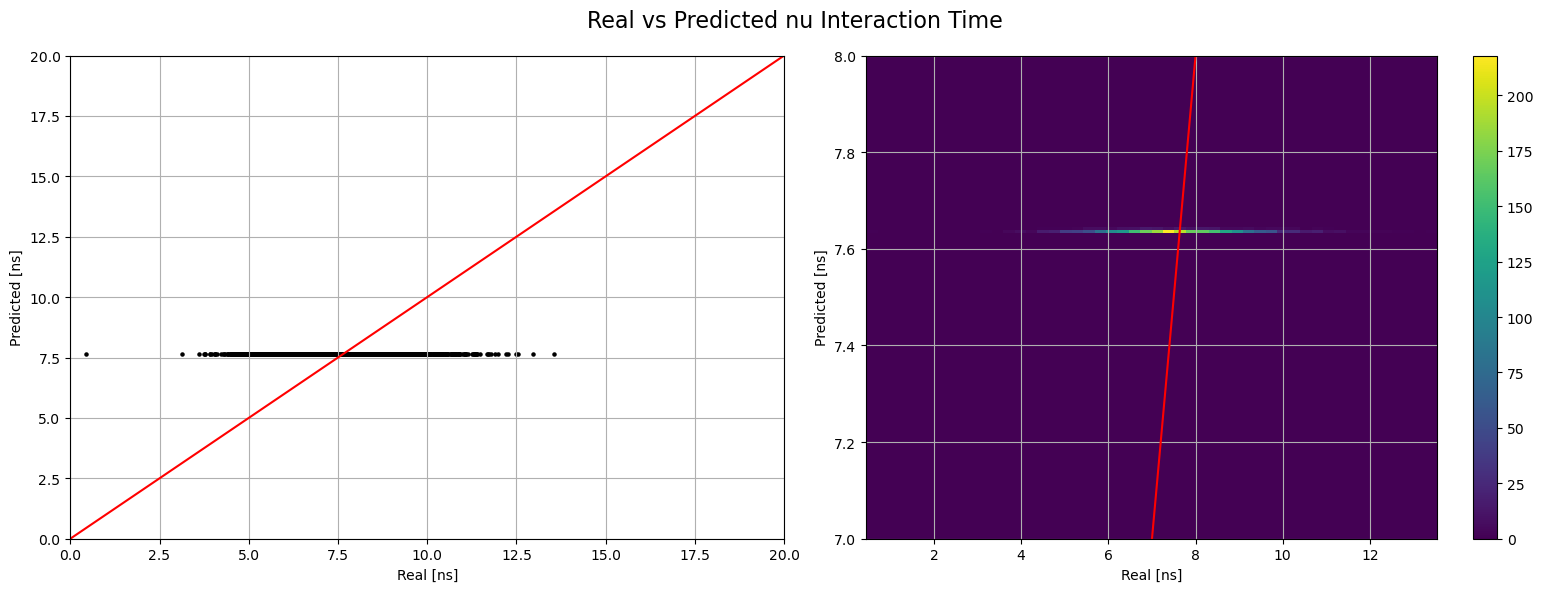

In [107]:
import matplotlib.pyplot as plt

# Assuming y_test_inverse and y_pred_inverse are numpy arrays
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axs[0].scatter(y_test_inverse, y_pred_inverse, color="black",s=5)
axs[0].grid()
axs[0].plot([0, 20], [0, 20], color="r")
axs[0].set_xlim([0, 20])
axs[0].set_ylim([0, 20])
axs[0].set_ylabel('Predicted [ns]')
axs[0].set_xlabel('Real [ns]')

# 2D Histogram
im0 = axs[1].hist2d(y_test_inverse.flatten(), y_pred_inverse.flatten(), bins=(50, 2), cmap='viridis')
fig.colorbar(im0[3], ax=axs[1])
axs[1].grid()
axs[1].plot([0, 20], [0, 20], 'r')
#axs[1].set_xlim([0, 20])
axs[1].set_ylim([7, 8])
axs[1].set_ylabel('Predicted [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')

# Adjust layout and show the plot
fig.suptitle('Real vs Predicted nu Interaction Time', size = 16)
fig.tight_layout()
plt.show()
#plt.savefig('/tmp/your_image.png', dpi=300)


**Gaussian fit of the residuals between prediction and actual data to check the quality of the results**

In [95]:
# Gaussian fit of the difference between the prediction and the real value

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred_realistic.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Data')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Edge"s fit')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Fit')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Count')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Mean nuvT =',popt_nuvT[1])
print('St. Dev. nuvT =',popt_nuvT[2])
print('------------------')


NameError: name 'nuvT_pred_realistic' is not defined

In [17]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

Gauss nuvT
115.17707820363492
24.574550175010334


## Visualización de las representaciones intermedias

Se visualiza las características intermedias aprendidas por la CNN. Se puede observar como la entrada se transforma al pasar através de las capas. Se selecciona una imagen aleatoria del conjunto de entrenamiento y se visualiza durante su transformación. Cada fila corresponde con una capa y cada imagen en la fila con un filtro.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

def visualize_intermediate_layers(model, x_train, sample_index=0):
    """
    Visualizes intermediate layer outputs for a specific sample from the training data.
    
    Parameters:
    - model: The trained Keras model.
    - x_train: The training data.
    - sample_index: Index of the sample from x_train to visualize.
    """
    # Get the outputs of all intermediate layers
    successive_outputs = [layer.output for layer in model.layers[1:]]
    visualization_model = Model(inputs=model.input, outputs=successive_outputs)
    
    # Select a sample image from x_train
    sample_image = x_train[sample_index:sample_index + 1]  # Shape should be (1, height, width, channels)
    
    # Pass the image through the model to get intermediate representations
    successive_feature_maps = visualization_model.predict(sample_image)
    
    # Get layer names for labeling
    layer_names = [layer.name for layer in model.layers[1:]]
    
    # Plot each layer's feature map
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:  # Only consider convolutional layers (ignore dense layers)
            n_features = feature_map.shape[-1]  # Number of filters
            size = feature_map.shape[1]  # Spatial dimensions
            
            # Create a grid for visualizing each filter's feature map
            display_grid = np.zeros((size, size * n_features))
            
            for i in range(n_features):
                x = feature_map[0, :, :, i]
                
                # Normalize the feature map values for better visualization
                x -= x.mean()
                x /= (x.std() + 1e-5)
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')
                
                # Resize or pad `x` if it doesn't match the expected dimensions
                if x.shape[1] < size:
                    x = np.pad(x, ((0, 0), (0, size - x.shape[1])), mode='constant')
                elif x.shape[1] > size:
                    x = x[:, :size]
                
                # Put each filter's activation in the display grid
                display_grid[:, i * size : (i + 1) * size] = x
            
            # Display the grid
            scale = 20. / n_features
            plt.figure(figsize=(scale * n_features, scale))
            plt.title(layer_name)
            plt.grid(False)
            plt.imshow(display_grid, aspect='auto', cmap='viridis')
            plt.show()

# Use the function to visualize intermediate representations of your model
# Assuming x_train is your training data and create_cnn_model has been defined
#model, _ = create_cnn_model(x_train, conv_dim=(3, 3), maxpool_dim=(2, 2))
#visualize_intermediate_layers(model, x_train)


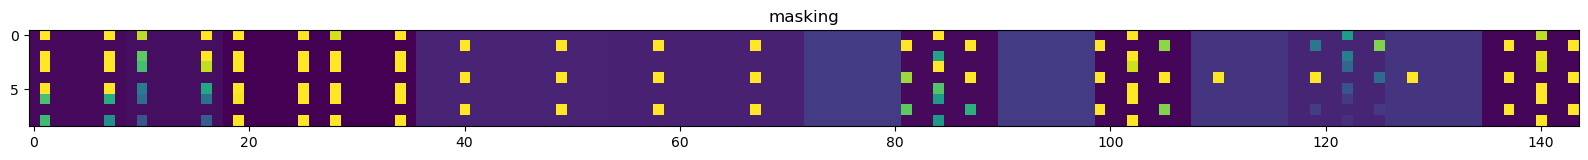

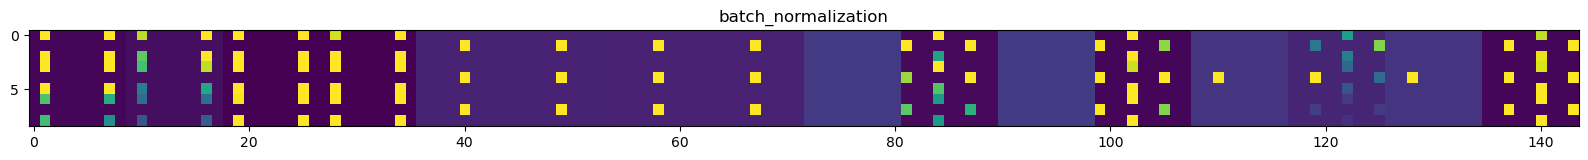

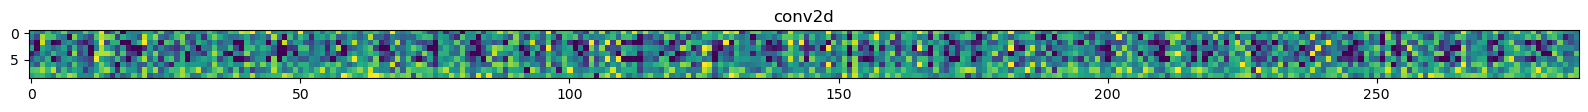

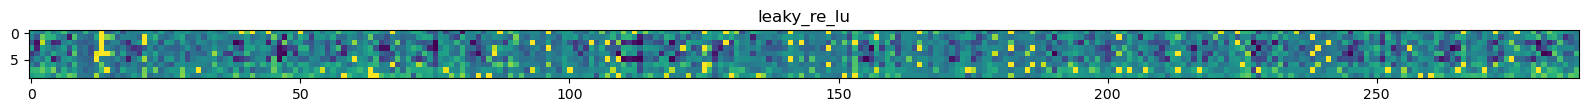

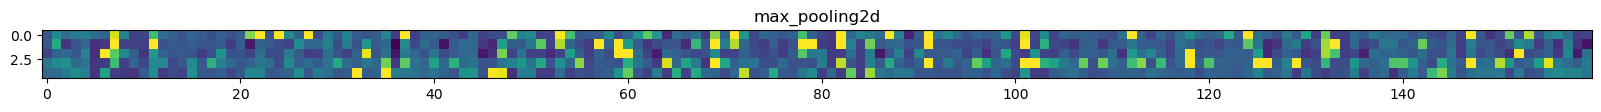

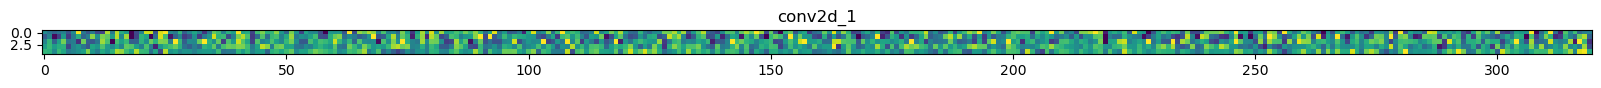

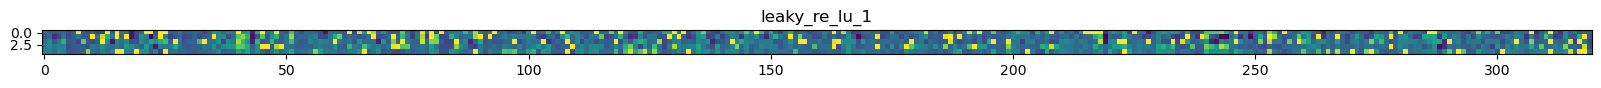

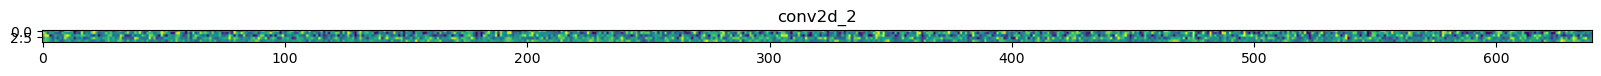

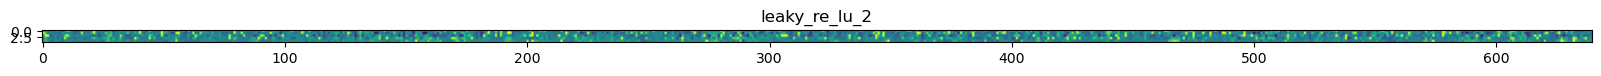

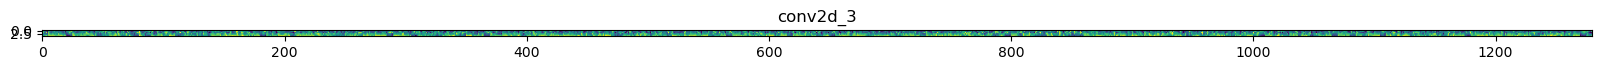

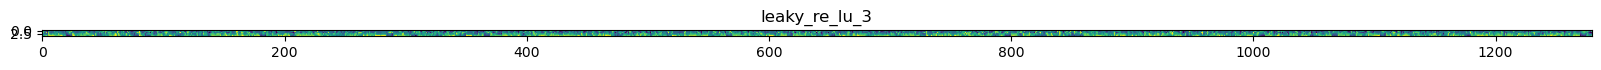

In [ ]:
visualize_intermediate_layers(model_compressed_4comp, x_train_compressed_4comp, sample_index=3)